# Развлекательное приложение Procrastinate Pro+. Исследование рекламной компании

Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки.\
Представлены данные о рекламном бюджете, пользовательских сессиях и покупках пользователей.\
Я проведу их анализ, чтобы разобраться в причинах не окупаемости маркетинга и помочь компании выйти в плюс.

## Поставленные вопросы:
1. Окупается ли реклама в целом?
2. Из чего состоят расходы на маркетинг?
3. Какие рекламные источники не окупаются?
4. Какие возможные причины не окупаемости этих источников?
5. Как страна, тип устройства и рекламный источник влияют на окупаемость?
6. Какие источники могут стать хорошей альтернативой для вложения в них большего бюджета?

### Ход исследования:

Данные для анализа я получаю из файлов:
- визиты: `/datasets/visits_info_short.csv`. Содержит информацию о сессиях пользователей с уканием даты и времени, а также страны, устройства и рекламного источника, откуда пользователь привлечён.
- заказы: `/datasets/orders_info_short.csv`. Включает информацию о покупках пользователей с указанием суммы.
- расходы: `/datasets/costs_info_short.csv`. Включает общие расходы на привлечение новых пользователей.

О качестве данных ничего не известно, поэтому я выполню их предобработку.\
После этого я проверю данные на явные и неявные дубликаты, а также на наличие пропусков.\
Далее я объявлю функции, которые позволят посчитать маркетинговые метрики LTV, ROI, CAC, конверсию и удержание, а также визуализировать их.

На следующем шаге я изучу расходы на маркетинг, чтобы получить информацию о каждом источнике: величина CAC, доля платящих клиентов и доля от общего бюджета.\
После я оценю общую окупаемость рекламной компании, а далее - оценю её в разбивке по каналам привлечения, устройствам и стране.\
Когда оценка окупаемости будет проведена, я оценю удержание и конверсию, также с разбивкой по категориям.\
Это позволит выявить источники, которые не окупаются - я найду причины, которые могли к этому привести, и дам рекомендации по их устранению.\
В конце исследования я выделю потенциально прибыльные источники рекламы, регионы и устройства, которые можно рассматривать как альтернативы для вложения большего бюджета.\
Таким образом, моё исследование пройдёт в **9** этапов:

1. Постановка вопросов
2. Предобработка данных и поиск пропусков/дубликатов
3. Введение функций для подсчета и визуализации метрик
4. Исследование расходов на маркетинг
5. Исследование окупаемости маркетинга, в целом и с разбивкой по категориям
6. Анализ конверсии и удержания, также общей и с разбивкой по источникам
7. Выявление причин, по которым некоторые каналы привлечения не окупаются
8. Подведение итога и финальные выводы
9. Рекомендации по потенциально прибыльным источникам

## Предобработка данных

Импортирую библиотеки, необходимые для работы:

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime, timedelta

Загружаю данные о визитах, заказах и рекламных расходах из CSV-файлов в переменные.

**Пути к файлам**

- визиты: `/datasets/visits_info_short.csv`.
- заказы: `/datasets/orders_info_short.csv`.
- расходы: `/datasets/costs_info_short.csv`.

Импортирую нужные библиотеки и загружаю таблицы:

In [2]:
try:
    sessions = pd.read_csv('/datasets/visits_info_short.csv')
    orders = pd.read_csv('/datasets/orders_info_short.csv')
    ad_costs = pd.read_csv('/datasets/costs_info_short.csv')
except:
    sessions = pd.read_csv('visits_info_short.csv')
    orders = pd.read_csv('orders_info_short.csv')
    ad_costs = pd.read_csv('costs_info_short.csv')

Просматриваю основную информацию о данных.

In [3]:
for i in [sessions, orders, ad_costs]:
    print(i.info())
    print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #

Привожу названия колонок к нижнему регистру, а также заменяю пробелы в названиях.\
Кроме этого меняю тип колонок, содержащих информацию о дате, на datetime, и вывожу информацию ещё раз.

In [4]:
for i in [sessions, orders, ad_costs]:
    i.columns = i.columns.str.lower()
    i.columns = i.columns.str.replace(' ', '_')
    for k in i.filter(regex='start|end|dt'):
        i[k] = pd.to_datetime(i[k])
    print(i.info())
    print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage

Готово. Теперь нужно найти возможные дубликаты.\
Все строковые значения в таблицах - это названия разных категорий, и в них могут встречаться повторы.\
Вывожу на экран информацию о таблицах, количество строк-дубликатов в них, а также список и количество уникальных названий категорий.\
Кроме этого вывожу категорию revenue из колонки orders, ведь она указывает на стоимость подписки.

In [5]:
for i in [sessions, orders, ad_costs]:
    print(i.info())
    print()
    dubles = len(i) - len(i.drop_duplicates())
    print(f'Количество строк-дубликатов: {dubles}')
    print()
    try:
        for h in ['channel', 'device', 'region','revenue']:
            try:
                count = i[h].value_counts()
                print(f'Уникальные категории в колонке {h}:')
                print(count)
                print()
            except:
                pass
    except:
        pass

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB
None

Количество строк-дубликатов: 0

Уникальные категории в колонке channel:
organic               107760
TipTop                 54794
FaceBoom               49022
WahooNetBanner         20465
LeapBob                17013
OppleCreativeMedia     16794
RocketSuperAds         12724
YRabbit                 9053
MediaTornado            8878
AdNonSense              6891
lambdaMediaAds          6507
Name: c

Готово, явных и неявных дубликатов в данных не обнаружено. Перехожу к функциям.

## Функции для вычисления метрик

In [6]:
def get_profiles(sessions, orders, ad_costs, event_names=[]):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # добавляем флаги для всех событий из event_names
    #for event in event_names:
    #   if event in events['event_name'].unique():
    #        profiles[event] = profiles['user_id'].isin(
    #            events.query('event_name == @event')['user_id'].unique()
    #        )

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    #объединяем траты на рекламу и число привлечённых пользователей
    new_users['dt'] = pd.to_datetime(new_users['dt'])
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles['dt'] = pd.to_datetime(profiles['dt'])
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [7]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [8]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [9]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

#### Функции для визуализации

In [10]:
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [11]:
def plot_retention(retention, retention_history, horizon, window=7):
    import warnings
    warnings.filterwarnings('ignore')
    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 
    warnings.filterwarnings('default')

In [12]:
def plot_conversion(conversion, conversion_history, horizon, window=7):
    import warnings
    warnings.filterwarnings('ignore')
    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 
    warnings.filterwarnings('default')

In [13]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):
    import warnings
    warnings.filterwarnings('ignore')
      
    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 
    warnings.filterwarnings('default')

In [14]:
# Функция для построения сводных таблиц, указывающих на долю платящих пользователей
def get_payers(df, dims, name):
    df = df.groupby(dims).agg({'first_ts':'count', 
                                          'payer':'sum'}).reset_index()
    df['dole'] = (df['payer'] / 
                   df['first_ts']).round(3)
    df['perc'] = (df['dole'] * 100).round(2)
    df.columns = [name, 'Количество польз-й', 'Количество платящих польз-й', 'Доля платящих', '%']
    df = df.set_index(name).sort_values('Доля платящих', ascending=False)
    return df

In [15]:
# Функция для получения информации о длительности пользовательской сессии,
# С фильтрацией по рекламным каналам
def channel_time(dim1, dim2, dims=False): # Если  dims=False, то срез делается по указанным источникам.
                                          # Если dims=True, то срез делается по всем остальным источникам, кроме указанных
    sess = sessions.copy()
    sess['dur'] = (sess['session_end'] - 
               sess['session_start']).dt.total_seconds()
    if dims == False:
        sess = sess[(sess['channel'] == dim1) | (sess['channel'] == dim2)]
        cost = profiles[['user_id', 'payer']]
        cst = cost.merge(sess, on='user_id', 
                       how='right')
        cst['date'] = pd.to_datetime(cst['session_start'])
    else:
        sess = sess[(sess['channel'] != dim1) & (sess['channel'] != dim2)]
        cost = profiles[['user_id', 'payer']]
        cst = cost.merge(sess, on='user_id', 
                       how='right')
        cst['date'] = pd.to_datetime(cst['session_start'])
    return cst[['user_id', 'payer', 'channel', 'region', 'device', 'dur']]

Последней задаю функцию, которая посчитает распределение рекламного бюджета по каналам:

In [16]:
def dynamic_days(df):
    import warnings
    warnings.filterwarnings('ignore')
    df2 = df.copy()
    df['week'] = df['dt'].dt.isocalendar().week
    df = df.groupby(['channel', 
                     'week']).agg({'costs':'sum'}).reset_index()
    df.pivot(index='week', columns='channel', 
             values='costs').plot(grid=True, figsize=(12,5))

    plt.xlim([df['week'].min(), 
              df['week'].max()])
    plt.ylim([0, 4500])
    plt.yticks(range(0, 4500, 500))
    plt.xticks(range(df['week'].min(), 
                     df['week'].max(), 1));

    plt.title('Динамика инвестиций в рекламу по неделям. Крупнейшие вложения')
    plt.xlabel('Номер недели')
    plt.ylabel('Инвестиции в рекламу');
    warnings.filterwarnings('default')

def dynamic_months(df):
    import warnings
    warnings.filterwarnings('ignore')
    df2 = df.copy()
    df['month'] = df['dt'].dt.month
    df = df.groupby(['channel', 
                     'month']).agg({'costs':'sum'}).reset_index()
    df.pivot(index='month', columns='channel', 
             values='costs').plot(grid=True, figsize=(12,5))

    plt.xlim([df['month'].min(), 
              df['month'].max()])
    plt.ylim([0, 14000])
    plt.yticks(range(0, 14000, 1000))
    plt.xticks(range(df['month'].min(), 
                     df['month'].max(), 1));

    plt.title('Динамика инвестиций в рекламу по месяцам. Крупнейшие вложения')
    plt.xlabel('Номер месяца')
    plt.ylabel('Инвестиции в рекламу');
    warnings.filterwarnings('default')

Все функции заданы, перехожу к анализу.


<div class="alert alert-success">
  
  <b>Комментарий ревьюера</b>
    
  ✔️ Отличные функции!
</div>

## Исследовательский анализ данных

Получаю профили пользователей и смотрю на даты привлечения:

In [17]:
profiles = get_profiles(sessions,
                       orders,
                       ad_costs)

min = profiles['first_ts'].min()
max = profiles['first_ts'].max()

print(f'минимальная дата привлечения клиентов: {min}')
print(f'максимальная дата привлечения: {max}')
profiles.head()

минимальная дата привлечения клиентов: 2019-05-01 00:00:41
максимальная дата привлечения: 2019-10-27 23:59:04


,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


Это значит, что в выборке есть информация о клиентах, привлечённых с 1 мая по 27 октября 2019 года.\
Даты соответствуют изначальному заданию.\
Смотрю на распределение клиентов по странам:

In [18]:
get_payers(profiles, 'region', 'Страна')      

,Количество польз-й,Количество платящих польз-й,Доля платящих,%
Страна,,,,
United States,100002,6902,0.069,6.9
Germany,14981,616,0.041,4.1
UK,17575,700,0.040,4.0
France,17450,663,0.038,3.8


Выводы:
* самая высокая доля платящих пользователей - в Америке, там платящие клиенты составляют 4.6% от всех пользователей из этой страны
* доля платящих клиентов из других стран мала и примерно одинакова - в районе 0.4 - 0.5%

Теперь - распределение по устройствам:

In [19]:
get_payers(profiles, 'device', 'Устройство')

,Количество польз-й,Количество платящих польз-й,Доля платящих,%
Устройство,,,,
Mac,30042,1912,0.064,6.4
iPhone,54479,3382,0.062,6.2
Android,35032,2050,0.059,5.9
PC,30455,1537,0.050,5.0


Выводы:
* самая высокая доля платящих - у пользователей, использующих Mac, она составляет 6.4% от всех пользователей с этим устройством
* На втором месте iPhone с 6.2% платящих
* самая низкая доля платящих - у пользователей PC, она составляет 5%

Доли платящих по рекламным источникам:

In [20]:
get_payers(profiles, 'channel', 'Канал привлечения')

,Количество польз-й,Количество платящих польз-й,Доля платящих,%
Канал привлечения,,,,
FaceBoom,29144,3557,0.122,12.2
AdNonSense,3880,440,0.113,11.3
lambdaMediaAds,2149,225,0.105,10.5
TipTop,19561,1878,0.096,9.6
RocketSuperAds,4448,352,0.079,7.9
WahooNetBanner,8553,453,0.053,5.3
YRabbit,4312,165,0.038,3.8
MediaTornado,4364,156,0.036,3.6
LeapBob,8553,262,0.031,3.1


Выводы:
* самая высокая доля платящих - у пользователей, привлеченных через FaceBoom, она составляет 12.2%
* на втором месте - AdNonSence, 11.3%
* далее идут lambdaMediaAds 10.5% и TipTop 9.6%
* самая низкая доля платящих - у YRabbit, MediaTornado, LeapBob и OppleCreativeMedia

### Маркетинг

Изучаю общие расходы на маркетинг. Изначальная таблица:

In [21]:
ad_costs.head()

,dt,channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


Оцениваю общие расходы:

In [22]:
total = ad_costs['costs'].sum().round(2)
print(f'общая сумма расходов на маркетинг: {total}')

общая сумма расходов на маркетинг: 105497.3


Теперь смотрю на распределение бюджета в зависимости от канала привлечения:

In [23]:
ch = ad_costs.groupby('channel').agg({'costs':'sum'}).reset_index()
ch['dole'] = (ch['costs'] / 
              ch['costs'].sum()).round(3)
ch['perc'] = (ch['dole'] * 100).round(2)
ch.columns = ['канал привлечения', 
              'расходы на маркетинг', 
              'доля от общего бюджета', '%']
ch = ch.set_index('канал привлечения').sort_values('расходы на маркетинг', 
                                              ascending=False)
ch

,расходы на маркетинг,доля от общего бюджета,%
канал привлечения,,,
TipTop,54751.30,0.519,51.9
FaceBoom,32445.60,0.308,30.8
WahooNetBanner,5151.00,0.049,4.9
AdNonSense,3911.25,0.037,3.7
OppleCreativeMedia,2151.25,0.020,2.0
RocketSuperAds,1833.00,0.017,1.7
LeapBob,1797.60,0.017,1.7
lambdaMediaAds,1557.60,0.015,1.5
MediaTornado,954.48,0.009,0.9


Заметно, что более половины рекламного бюджета, 52%, вкладывалось в рекламу через TipTop, а треть, 31% - в рекламу на FaceBoom.\
Кроме них покупалась реклама ещё на 8 площадках, однако доля закупок в каждой из них составила не более 5% от общего бюджета, а в сумме они составляют 17% общего бюджета.\
Смотрю на распределение инвестиций в рекламу по дням:

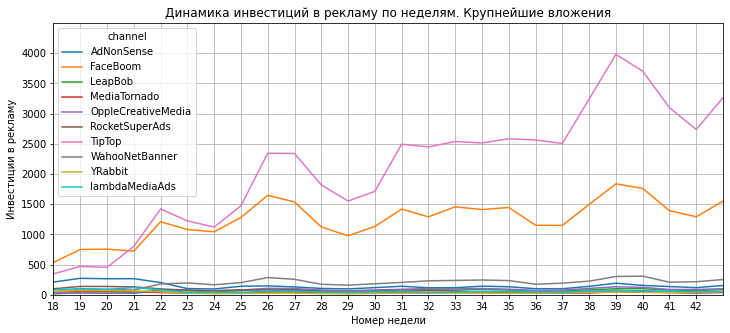

In [24]:
dynamic_days(ad_costs)

Заметно, что в течение рекламной компании постоянно повышались вложения в TipTop и Faceboom, вложения в остальные источники находились примерно на одном уровне весь период анализа.

Это также заметно в разбивке по месяцам:

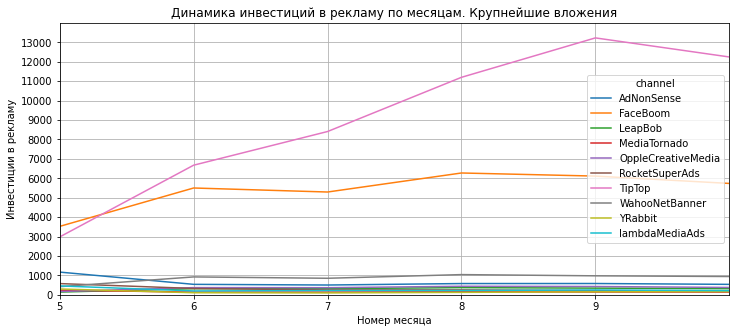

In [25]:
dynamic_months(ad_costs)

Стоит отметить, что вложения в FaceBoom хоть и были выше остальных каналов, но в динамике они держались примерно на одном уровне.\
Чего не скажешь о TipTop - с каждым месяцем объёмы вложений продолжали расти.

теперь оцениваю стоимость привлечения одного пользователя с каждой площадки.\
Я использую функцию для получения профилей - она также считает CAC, или стоимость привлечения клиента.

In [26]:
cac = get_profiles(sessions, 
                   orders, 
                   ad_costs).query('channel != "organic"'
                                  ).groupby('channel').agg(
                                                   {'acquisition_cost': 'mean'}
                                                   ).round(3).reset_index()
cac.columns = ['канал привлечения', 
               'Стоимость привл-я 1 клиента']
cac = cac.set_index('канал привлечения').sort_values('Стоимость привл-я 1 клиента')
cac_mean = cac['Стоимость привл-я 1 клиента'].mean().round(2)
display(cac,
      (f'Средний САС на одного клиента для всего проекта:{cac_mean}'),
     )


,Стоимость привл-я 1 клиента
канал привлечения,
LeapBob,0.210
MediaTornado,0.219
YRabbit,0.219
OppleCreativeMedia,0.250
RocketSuperAds,0.412
WahooNetBanner,0.602
lambdaMediaAds,0.725
AdNonSense,1.008
FaceBoom,1.113


'Средний САС на одного клиента для всего проекта:0.76'

Органические пользователи не затрачивают бюджета маркетинга.\
Самая низкая стоимость привлечения - у площадки LeapBob, самая высокая - у TipTop, FaceBoom и AdNonSence. Также у этих популярных каналов САС, или стоимость привлечения одного клиента, выше средней по всему проекту.

**Промежуточный вывод**:
* более 80% бюджета вложено в TipTop и Faceboom
* инвестиции в эти источники постоянно росли в динамике, а инвестиции в остальные источники оставались в среднем на одном уровне
* TipTop, FaceBoom и AdNonSence имеют самую высокую стоимость привлечения клиента, заметно выше средней по проекту. Популярные площадки - дороже
* Дешевле всего обходятся клиенты, пришедшие через LeapBob, MediaTornado и Yrabbit

Теперь можно рассмотреть окупаемость рекламы.

### Окупаемость маркетинга

В качестве даты обзора использую 1 ноября 2019 года. В бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения, поэтому устанавливаю горизонт анализа в 14 дней.

In [27]:
observation_date = datetime(2019, 11, 1)
horizon_days = 14

Поскольку далее рассматриваю окупаемость - вначале убираю данные об органичных пользователях, ведь они не затрагивают бюджет.

In [28]:
profiles = profiles.query('channel != "organic"')

Сначала оценю общую окупаемость, для этого визуализирую метрики:

**LTV** - пожизненная ценность клиента (сумма доходов, полученных с одного клиента)\
**ROI** - окупаемость инвестиций

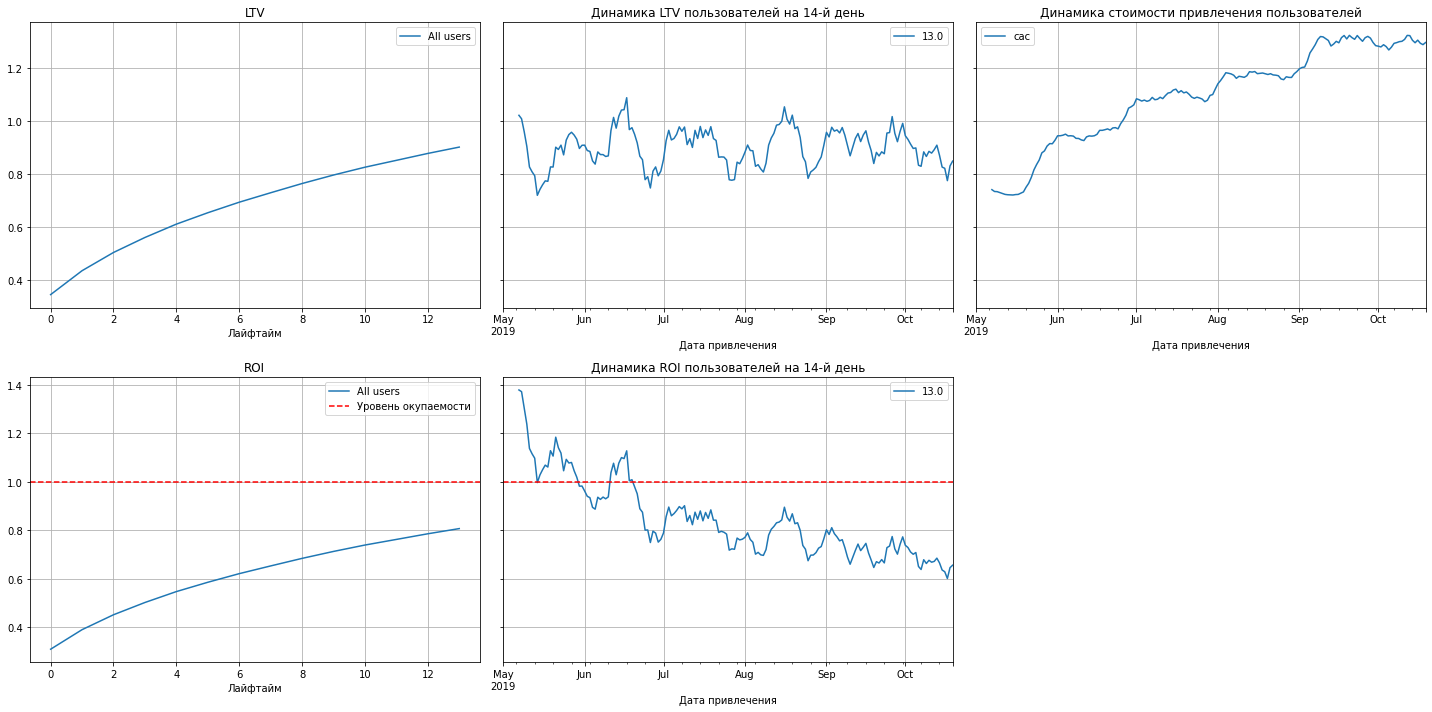

In [29]:
result_raw, ltv, ltv_time, roi, roi_time = get_ltv(profiles, 
                                                   orders, 
                                                   observation_date, 
                                                   horizon_days)
plot_ltv_roi(ltv, ltv_time, 
             roi, roi_time, 
             horizon_days)

Из графиков можно сделать выводы:
* Реклама не окупается - ROI не достигает уровня окупаемости
* LTV стабилен - значит, дело не в качестве пользователей
* Динамика стоимости привлечения нестабильна и сильно растёт в весь период анализа
* Окупаемость постоянно падает в динамике, в середине июня реклама перестаёт окупаться. Именно в июне начались постоянно растущие вложения в TipTop

## Анализ окупаемости с разбивкой по категориям

#### Разные страны

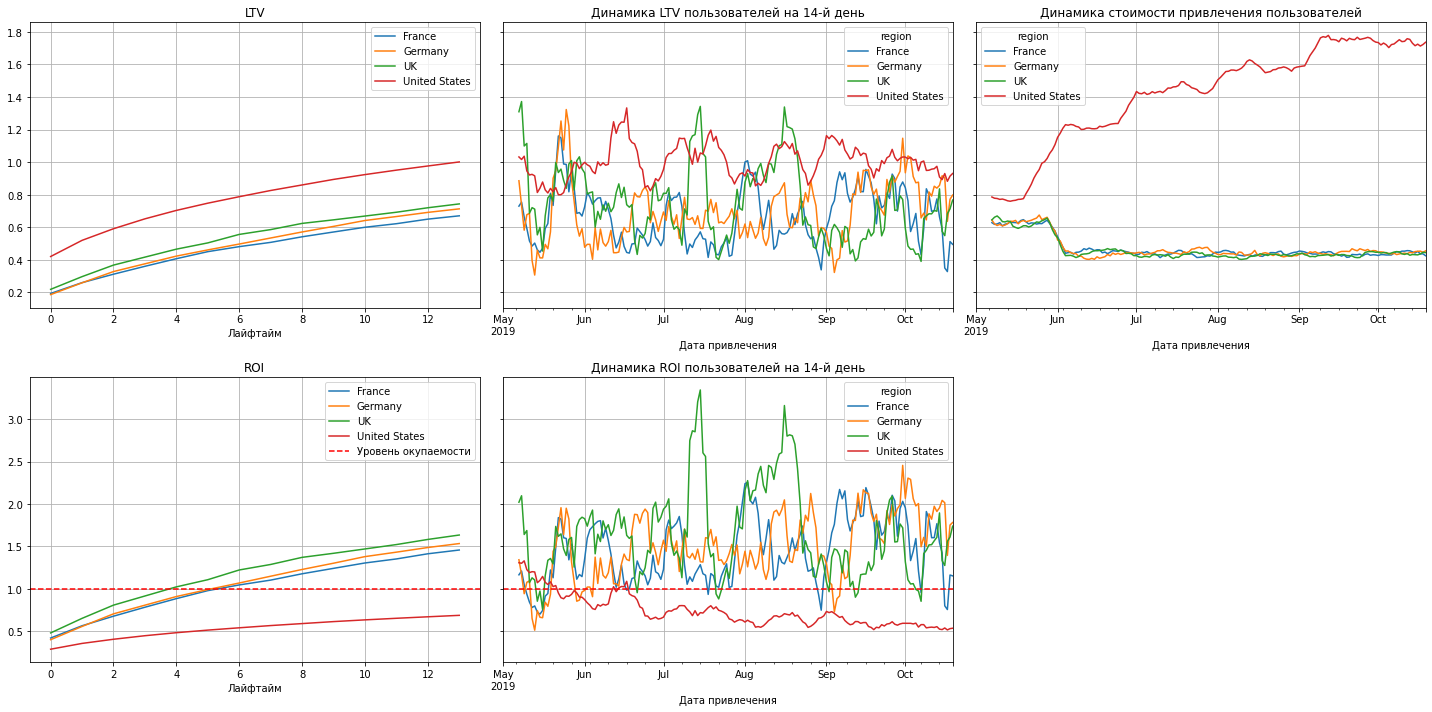

In [30]:
result_raw, ltv, ltv_time, roi, roi_time = get_ltv(profiles, 
                                                   orders, 
                                                   observation_date, 
                                                   horizon_days,
                                                   dimensions=['region'])
plot_ltv_roi(ltv, ltv_time, 
             roi, roi_time, 
             horizon_days)

Заметно, что пожизненная ценность клиента в Америке выше, чем в остальных странах.\
При это окупаются пользователи из всех стран, кроме Америки.\
Динамика стоимости привлечения для всех стран, кроме Америки, стабильна. в Америке же стоимость резко расёт с середины мая по начало июня, и продолжает расти вплоть до октября.\
Динамика окупаемости в Америке также падает, начиная с мая, и уже в середине июня падает ниже уровня окупаемости.\
Среди окупаемых стран можно отметить Британию - там окупаемость периодически достигает очень высоких значений в сравнении с остальными странами.

Отдельно изучаю пользователей из Америки:



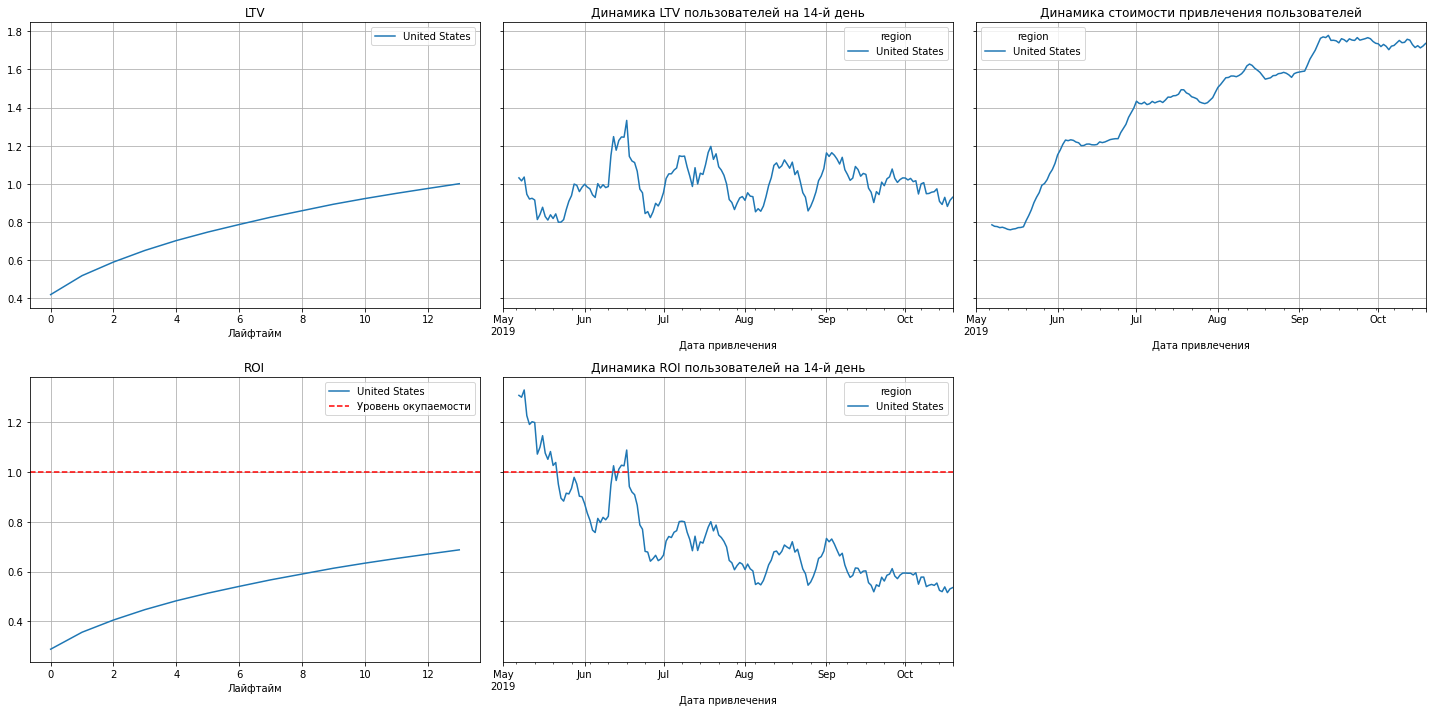

In [31]:
result_raw, ltv, ltv_time, roi, roi_time = get_ltv(profiles.query('region == "United States"'), 
                                                   orders, 
                                                   observation_date, 
                                                   horizon_days,
                                                   dimensions=['region'])
plot_ltv_roi(ltv, ltv_time, 
             roi, roi_time, 
             horizon_days)

**Выводы:**
* Больше всего платят клиенты из Америки, однако они не окупаются
* В динамике они окупались с мая по середину июня, после чего перестали окупаться, при этом окупаемость продолжает падать
* Стоимость привлечения пользователей из Америки в динамике очень сильно растёт в районе июня, после чего продолжает увеличиваться, а стоимость привлечения по другим странам - остаётся на одном уровне
* Хорошие пики окупаемости показывает Британия

#### Разные устройства

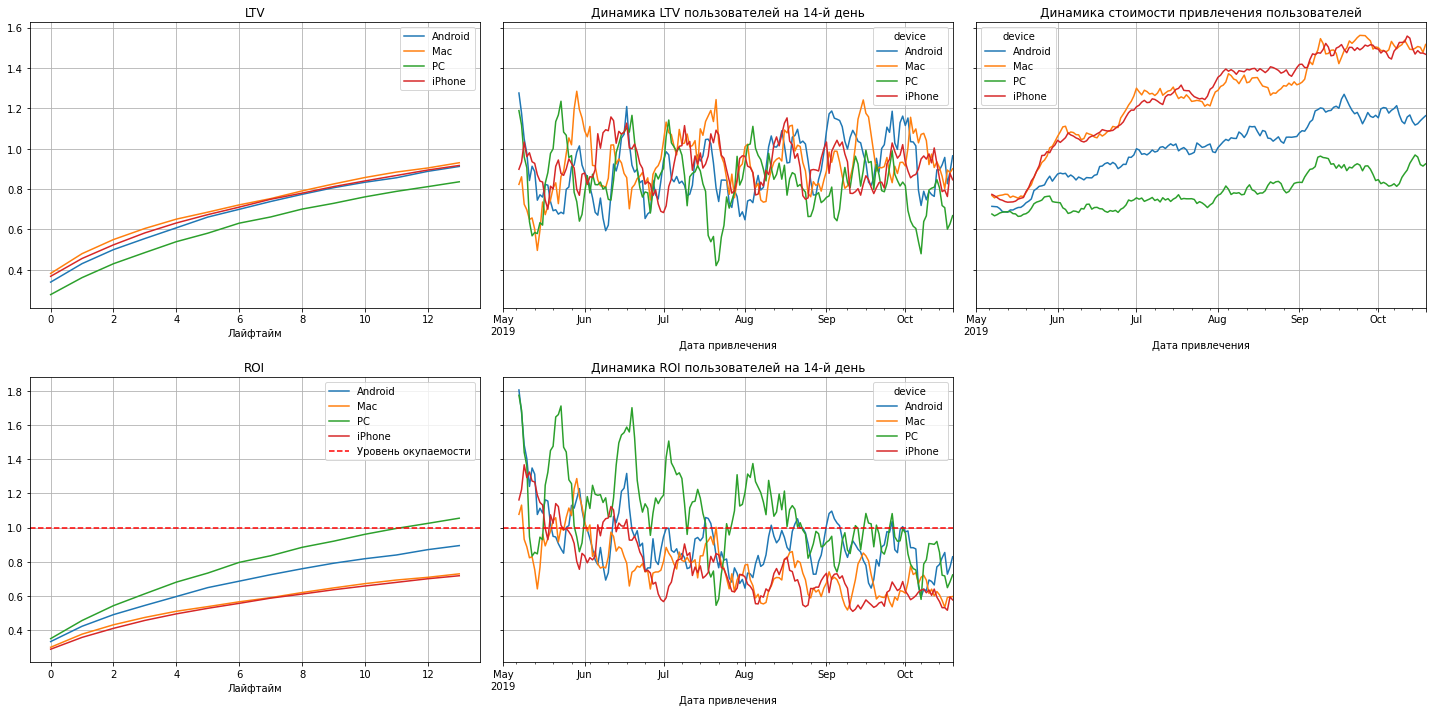

In [32]:
result_raw, ltv, ltv_time, roi, roi_time = get_ltv(profiles, 
                                                   orders, 
                                                   observation_date, 
                                                   horizon_days,
                                                   dimensions=['device'])
plot_ltv_roi(ltv, ltv_time, 
             roi, roi_time, 
             horizon_days)

Из графиков видно, что окупаются только пользователи, использующие PC, причем только к концу 2х недель, едва пересекая границу окупаемости.\
Самая низкая окупаемость - у iPhone и Mac, немного лучше обстоят дела с Android.\
Все платформы приносят в среднем одинаковое количество прибыли, PC - меньше всех\
На динамике окупаемости самый лучший результат показывает PC, достигая высоких значений в сравнении с остальными девайсами.\
Динамика стоимости показывает, что быстрее и сильнее всех растет стоимость привлечения пользователей с iPhone и Mac, что также связано с падением окупаемости. Кроме этого заметен рост стоимость привлечения клиентов с Android. У PC стоимость привлечения растет незначительно.

**Выводы:**
* Пользователи с iPhone, Mac и Android не окупаются
* Пользователи с PC - окупаются
* Пожизненная ценность клиента в динамике находится на одном уровне
* Худшая окупаемость - у клиентов с Iphone и Mac 
* На динамике окупаемость по всем девайсам постоянно падает, самые высокие значения - у ПК, но и он падает ниже границы окупаемости во второй половине августа
* Самая быстрый рост "стоимости" клиента в динамике - у iPhone и Mac, стоимость привлечения у них на одинаково высоком уровне
* Меньше всего "стоят" клиенты с ПК

#### Каналы привлечения

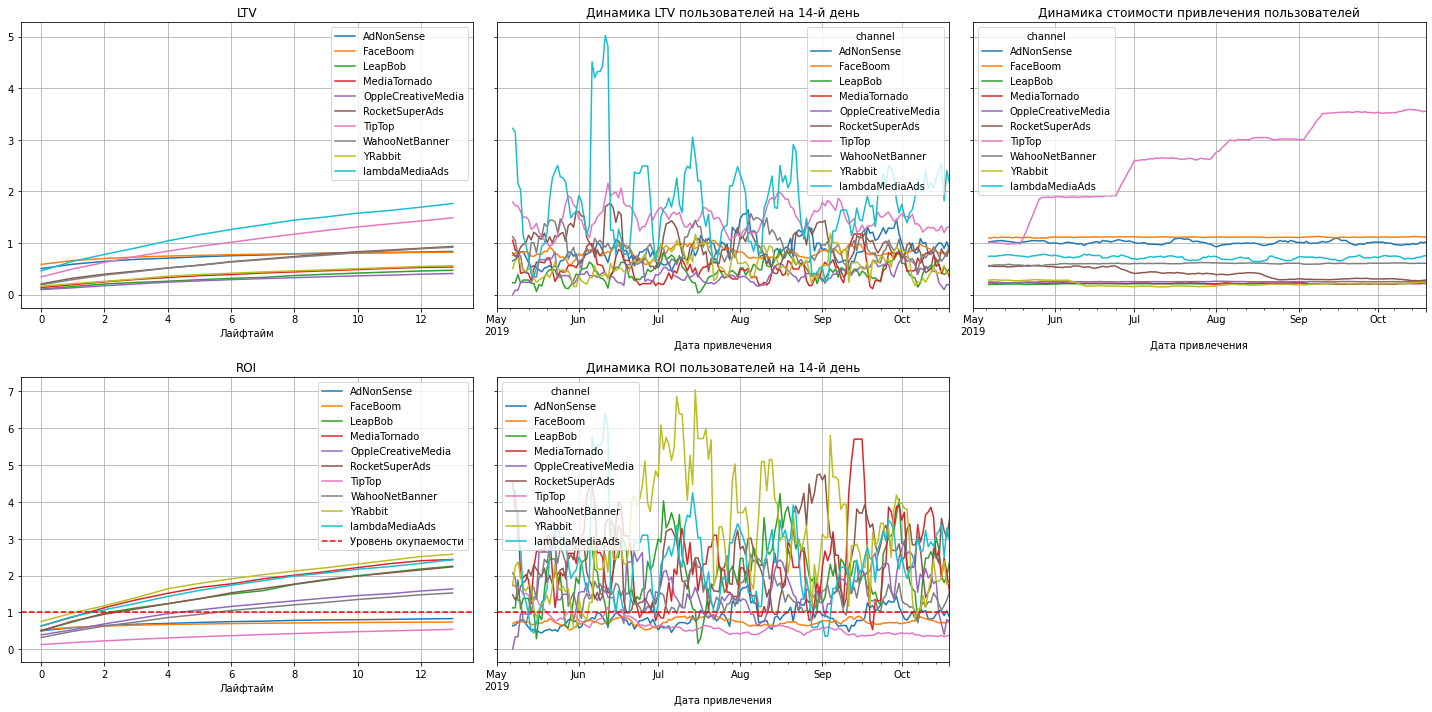

In [33]:
result_raw, ltv, ltv_time, roi, roi_time = get_ltv(profiles, 
                                                   orders, 
                                                   observation_date, 
                                                   horizon_days,
                                                   dimensions=['channel'])
plot_ltv_roi(ltv, ltv_time, 
             roi, roi_time, 
             horizon_days)

Самую высокую пожизненную стоимость клиента показывают каналы LamdaMediaAds и TipTop.\
Однако при этом TipTop, Faceboom и AdNonSence не окупаются.\
Самую высокую динамику стоимости привлечения показывает TipTop: видно, что каждый месяц количество вложений заметно растёт, в то время как этот показатель по другим каналам остаётся стабильно на одном уровне.

Выделяю TipTop:

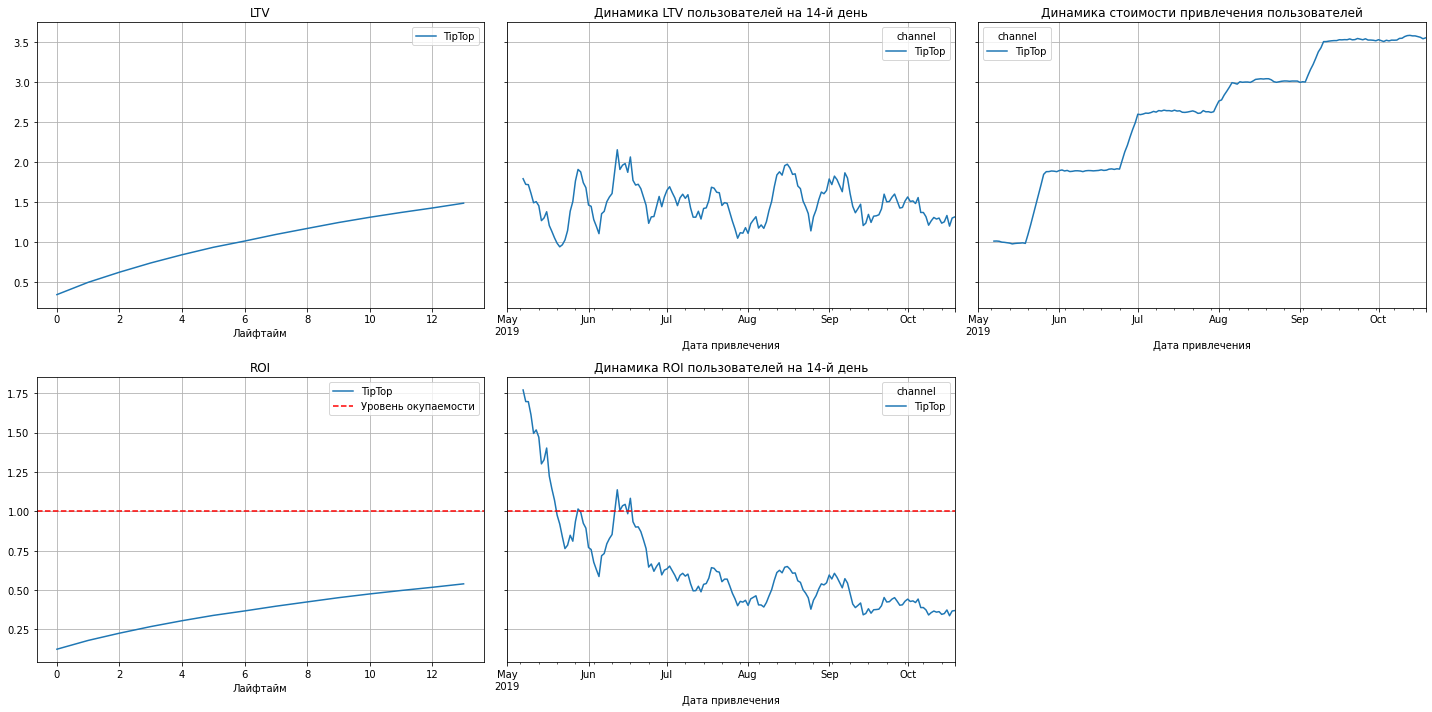

In [34]:
result_raw, ltv, ltv_time, roi, roi_time = get_ltv(profiles.query('channel == "TipTop"'), 
                                                   orders, 
                                                   observation_date, 
                                                   horizon_days,
                                                   dimensions=['channel'])
plot_ltv_roi(ltv, ltv_time, 
             roi, roi_time, 
             horizon_days)

А также AdNonSence:

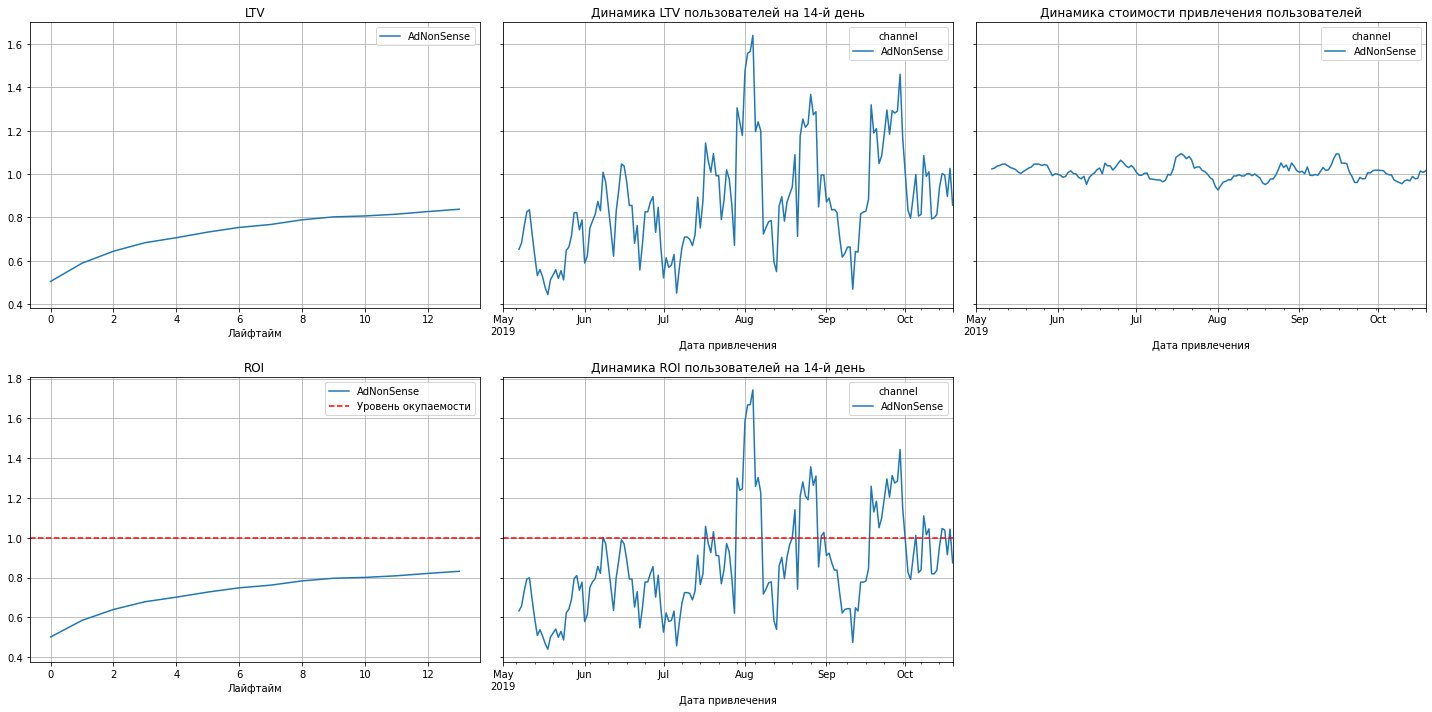

In [35]:
result_raw, ltv, ltv_time, roi, roi_time = get_ltv(profiles.query('channel == "AdNonSense"'), 
                                                   orders, 
                                                   observation_date, 
                                                   horizon_days,
                                                   dimensions=['channel'])
plot_ltv_roi(ltv, ltv_time, 
             roi, roi_time, 
             horizon_days)

**Вывод**:
* Лучше всего окупаются YRabbit, MediaTornado и lambdaMediaAds
* TipTop, FaceBoom и AdNonSence не окупаются
* У AdNonSense LTV в динамике очень нестабилен, а также заметно совпадает совпадает ROI. Причина неокупаемости может крыться в "качестве" пользователей
* Стоимость привлечения у TipTop постоянно увеличивалась с каждым месяцем, имея характерные "периоды" роста стоимости
* Стоимость привлечения по остальным каналам оставалась примерно на одном уровне
* Самая высокая пожизненная стоимость клиента - у LambdaMediaAds и TipTop
* В динамике пожизненная стоимость сильнее всего поднималась у lambdaMediaAds и постоянно росла, у остальных каналов она находится на одном уровне

## Конверсия

Теперь оцениваю конверсию для каждой категории:

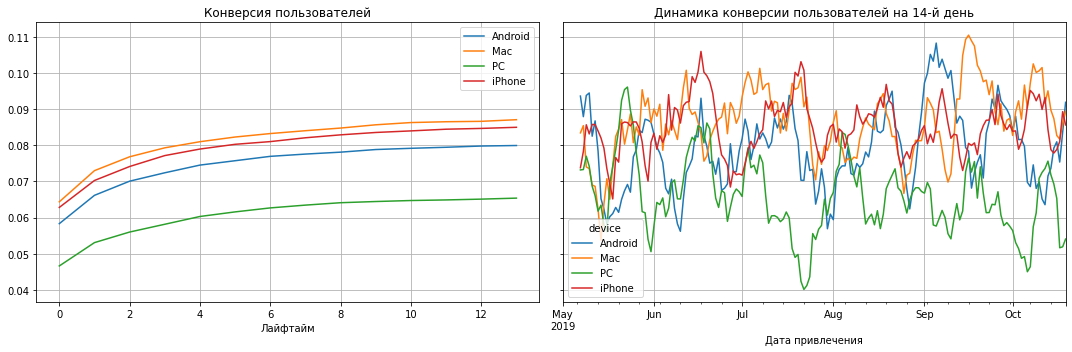

In [36]:
conversion_raw, conversion, conversion_time = get_conversion(profiles, 
                                                             orders, 
                                                             observation_date, 
                                                             horizon_days,
                                                             dimensions=['device'])
plot_conversion(conversion, 
                conversion_time, 
                horizon_days)

Заметно, что самая низкая конверсия - у пользователей с PC.\
Теперь смотрю конверсию по странам:

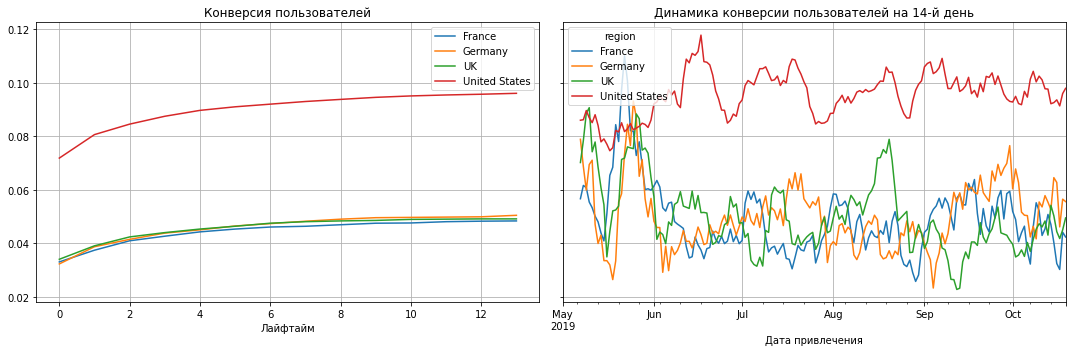

In [37]:
conversion_raw, conversion, conversion_time = get_conversion(profiles, 
                                                             orders, 
                                                             observation_date, 
                                                             horizon_days,
                                                             dimensions=['region'])
plot_conversion(conversion, 
                conversion_time, 
                horizon_days)

Хорошо видно, что конверсия пользователей из Америки существенно выше, чем конверсия по остальным странам. \
Теперь смотрю на каналы привлечения:

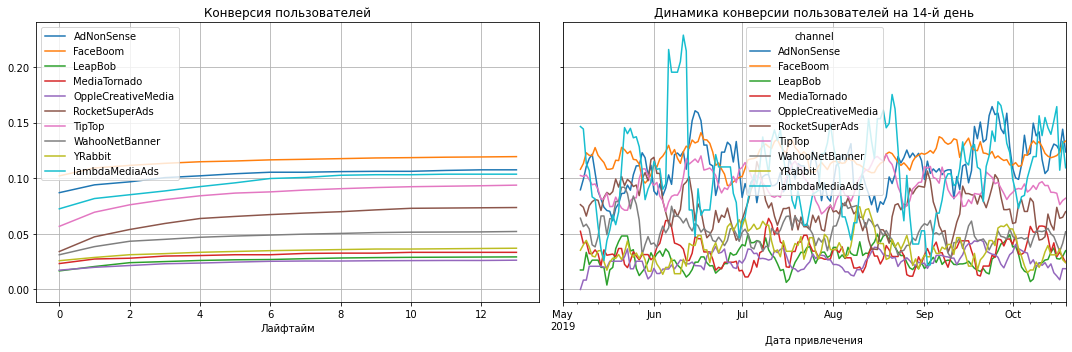

In [38]:
conversion_raw, conversion, conversion_time = get_conversion(profiles, 
                                                             orders, 
                                                             observation_date, 
                                                             horizon_days,
                                                             dimensions=['channel'])
plot_conversion(conversion, 
                conversion_time, 
                horizon_days)

Самая высокая конверсия наблюдается у пользователей, привлеченных через FaceBoom, AdNonSence, TipTop и lambdaMediaAds.
Конверсия по остальным источникам незначительна, за исключением RocketSuperAds и WahooNetBanner.

**Выводы**: 
* Самая низкая конверсия - у пользователей, использующих ПК
* Конверсия пользователей в Америке - гораздо выше, чем во Франции, Британии и Германии. В них конверсия одинакова
* Самая высокая конверсия по источнику - у Faceboom, далее идут AdNonSence, lambddaMediaAds и TipTop
* Источники RocketSuperAds и WahooNetBanner имеют среднюю конверсию, а остальные - совсем низкую
* Самые большие скачки конверсии в динамике по месяцам - у lambdaMediaAds, клиенты из этого источника хорошо конвертируются, реклама дает эффект
* Faceboom и AdNonSence также хорошо показывают себя в динамике

### Удержание

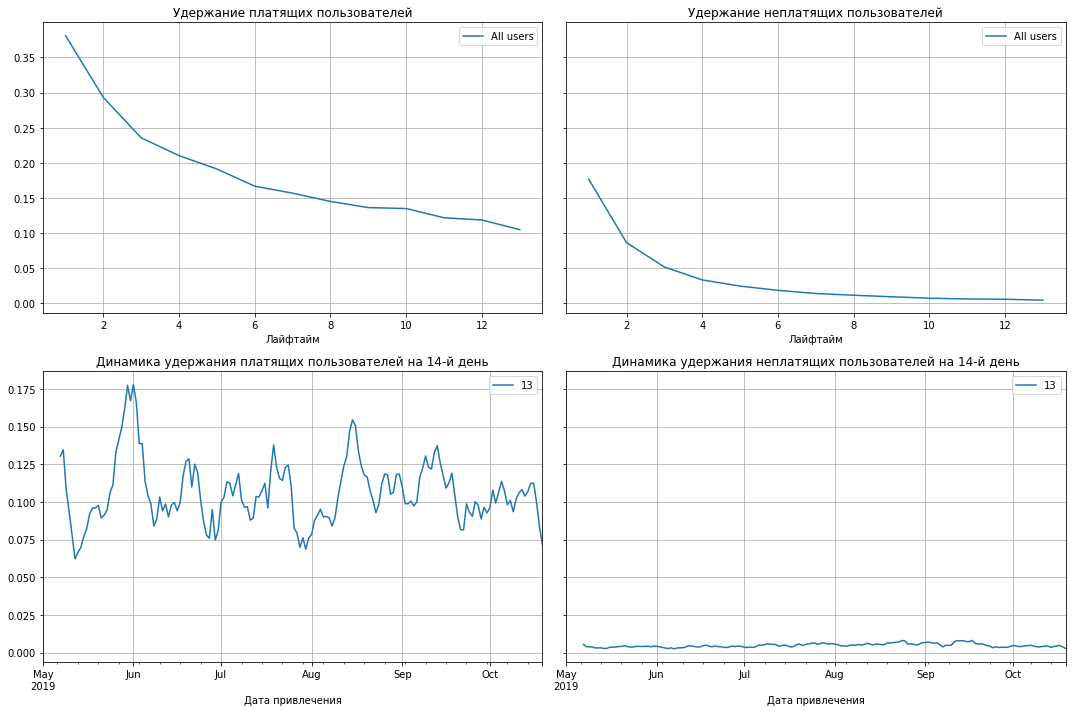

In [39]:
retention_raw, retention, retention_time = get_retention(profiles, sessions, observation_date, 14)
report = retention_time.query('payer == False')

plot_retention(retention, retention_time, horizon=14)

Интересная картина: динамика удержания неплатящих пользователей на 14й день находится у отметки в 0, практически не изменяясь за весь период анализа. Неплатящие пользователи почти не удерживаются в приложении - удержание сильно падает уже на 4й день, а к концу периода анализа и вовсе падает до нуля.\
Динамика удержания платящих пользователей имеет нормальный вид и находится в среднем на одном уровне.Она имеет характерные пики - вероятно, это периоды вложения в рекламу, или обновлений.\
Удержание платящих и неплатящих пользователей имеет нормальный вид, постепенно снижаясь.\
У платящих оно ожидаемо выше, чем у неплатящих.


**Вывод:**
* Неплатящие пользователи всех категорий не удерживаются в приложении, удержание незначительно и сильно падает уже к 4му дню. В динамике - картина такая же: весь период обзора удержание почти нулевое

Провожу разбивку удержания по каналам:

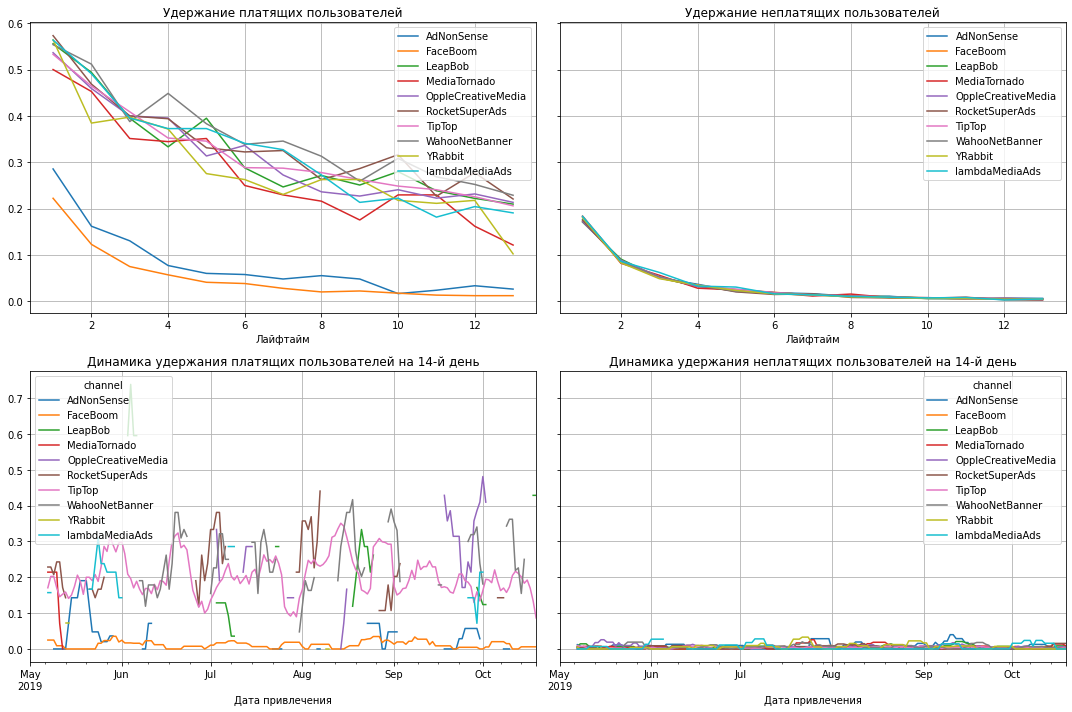

In [40]:
retention_raw, retention, retention_time = get_retention(profiles, sessions, observation_date, 14, dimensions=['channel'])

plot_retention(retention, retention_time, horizon=14)

Удержание платящих клиентов, пришедших по рекламе в FaceBoom и AdNonSence, существенно ниже удержания по остальным каналам.
Динамика удержания платящих имеет нормальный вид. Заметно, что удержание платящих клиентов, пришедших через FaceBoom, было на нулевом уровне практически ведь период анализа.\
Также есть интересный пик удержания по каналу LeapBob - возможно, это была удачно проведённая акция.\
Динамика удержащия платящих также находится на нуле, дело не канале привлечения.

**Выводы:**
* Самая низкое и почти нулевое к 14-му дню удержание - у FaceBoom и AdNonSence. Платящие пользователи, пришедшие через эти каналы, удерживаются не лучше неплатящих. Это и стало причиной неокупаемости каналов
* Самое высокое и стабильное удержание - у клиентов, пришедших через WahooNetBanner
* В конце двух недель стремится к нулю удержание каналов MediaTornado и YRabbit
* В динамике самые большие пики удержания показывают RocketSuperAds и OppleCreativeMedia
* В динамике удержание FaceBoom все время анализа остаётся у нуля

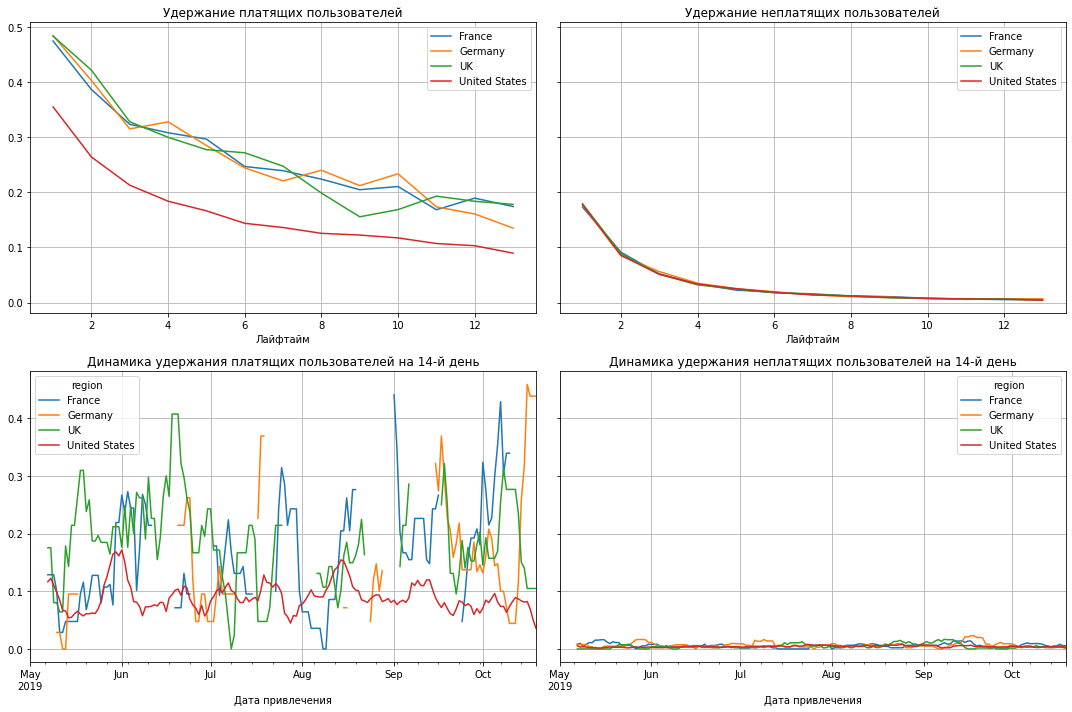

In [41]:
retention_raw, retention, retention_time = get_retention(profiles, sessions, observation_date, 14, dimensions=['region'])

plot_retention(retention, retention_time, horizon=14)

Удержание платящих пользователей из Америки ниже, чем у остальных стран.\
По динамике удержания платящих также заметно, что показатели по клиентам из Америки находятся на низком уровне и почти не меняются за все время анализа.\
Динамика удержания неплатящих пользователей также на нуле.

**Выводы:**
* Самое низкое удержание платящих игроков - в Америке, на динамике оно также не показывает особого роста
* В динамике удержание в Британии, Германии и Франции даёт пики с высокими значениями, реклама работает
* Самые высокий пик удержания был во Франции в начале сентября, возможно, была успешная кампания

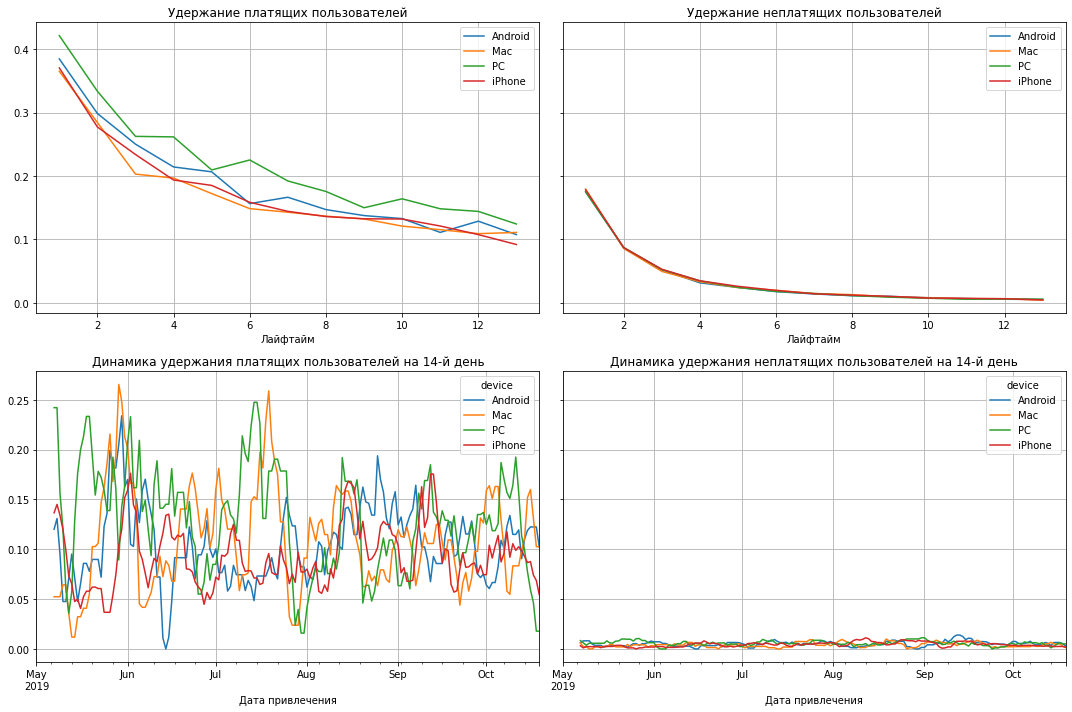

In [42]:
retention_raw, retention, retention_time = get_retention(profiles, sessions, observation_date, 14, dimensions=['device'])
plot_retention(retention, retention_time, horizon=14)

Удержание по всем устройствам находится на одном уровне. На динамике удержания заметно, что для PC оно было достаточно высоким в середине мая, понизилось в июле, и вновь заметно выросло под конец июля.\
Удержание неплатящих в динамике - аналогично нулёвое.

**Выводы:**
* Платящие пользователи, использующие ПК, показывают самое высокое удержание среди всех девайсов, как в момент обзора, так и в динамике
* Платящие с Maс и iPhne показывают самое низкое удержание в моменте, однако на динамике есть значительные пики удержания

## Общие выводы по окупаемости, удержанию, конверсии

Сопоставляю все выводы, а также вывожу информацию о распределении рекламного бюджета.\
Для наглядности обновляю таблицу вложений в рекламу, добавляю инфо об окупаемости, стоимости 1го клиента и количестве привлеченных клиентов.\
В таблице нет органичных пользователей - их процент от всего количества привлечённых клиентов составляет 37.6%

In [43]:
def no_roi(column):
    if column in (['TipTop', 
                   'FaceBoom',
                   'AdNonSense' 
                   ]):
        column = 'Нет'
    else:
        column = 'Да'
    return column          
ch_roi = ch.reset_index()
ch_roi['Окупается'] = ch_roi['канал привлечения'].apply(no_roi)
ch_roi = ch_roi.merge(cac, on='канал привлечения', 
                           how='left')
us = profiles.groupby('channel').agg({'dt':'count'}).reset_index()
us['dole'] = ((us['dt']/
              us['dt'].sum()) * 100).round(2)
us.columns = ['канал привлечения',
              'Привлечено',
              '% от всех пришедших ']
ch_roi.merge(us, on='канал привлечения', 
                 how='left').set_index('канал привлечения')

,расходы на маркетинг,доля от общего бюджета,%,Окупается,Стоимость привл-я 1 клиента,Привлечено,% от всех пришедших
канал привлечения,,,,,,,
TipTop,54751.30,0.519,51.9,Нет,2.799,19561,20.91
FaceBoom,32445.60,0.308,30.8,Нет,1.113,29144,31.15
WahooNetBanner,5151.00,0.049,4.9,Да,0.602,8553,9.14
AdNonSense,3911.25,0.037,3.7,Нет,1.008,3880,4.15
OppleCreativeMedia,2151.25,0.020,2.0,Да,0.250,8605,9.20
RocketSuperAds,1833.00,0.017,1.7,Да,0.412,4448,4.75
LeapBob,1797.60,0.017,1.7,Да,0.210,8553,9.14
lambdaMediaAds,1557.60,0.015,1.5,Да,0.725,2149,2.30
MediaTornado,954.48,0.009,0.9,Да,0.219,4364,4.66


**Общий вывод по окупаемости и удержанию**
* Реклама в целом не окупается
* Более 80% бюджета вложено в TipTop и FaceBoom, которые не окупается, и который имеет самую высокую стоимость клиента. Также не окупается  AdNonSence
* LTV стабилен - значит, дело не в качестве пользователей
* Динамика стоимости привлечения нестабильна и сильно растёт в весь период анализа
* Реклама окупалась первую половину периода анализа с мая по июль, а с августа - перестала окупаться

* Неплатящие пользователи всех категорий не удерживаются в приложении, удержание незначительно и сильно падает уже к 4му дню. В динамике - картина такая же: весь период обзора удержание почти нулевое

**Окупаемость**
* Лучше всего окупаются YRabbit, MediaTornado и lambdaMediaAds
* TipTop, FaceBoom и AdNonSence не окупаются
* Самая высокая пожизненная стоимость клиента - у LambdaMediaAds и TipTop
* В динамике пожизненная стоимость сильнее всего поднималась у lambdaMediaAds и постоянно росла, у остальных каналов она находится на одном уровне
* Самые большие пики окупаемости в динамике давала реклама на Yrabbit, реклама особенно хорошо работала с июня по середину июля


* Пожизненная ценность клиента (по устройству) в динамике находится на одном уровне
* Окупаются только клиенты с ПК. Остальные платформы - нет. Самые низкие значения - у iPhone и Mac.
* На динамике окупаемость по всем девайсам постоянно падает, самые высокие значения - у ПК
* Самая быстрый рост "стоимости" клиента в динамике - у iPhone и Mac
* Меньше всего "стоят" клиенты с ПК


* Больше всего платят клиенты из Америки, однако они не окупаются
* В динамике они окупались с мая по середину июня, после чего перестали окупаться, при этом окупаемость продолжает падать
* Стоимость привлечения пользователей из Америки в динамике очень сильно растёт в районе июня, после чего продолжает увеличиваться, а стоимость привлечения по другим странам - остаётся на одном уровне
* Хорошие пики окупаемости показывает Британия



**Конверсия**
* Самая высокая конверсия по источнику - у Faceboom, далее идут AdNonSence, lambddaMediaAds и TipTop
* Источники RocketSuperAds и WahooNetBanner имеют среднюю конверсию, а остальные - совсем низкую
* Самая низкая конверсия по устройству - у пользователей, использующих ПК
* Конверсия пользователей в Америке - гораздо выше, чем во Франции, Британии и Германии. В них конверсия одинакова

* Самые большие скачки конверсии в динамике по месяцам - у lambdaMediaAds, клиенты из этого источника хорошо конвертируются, реклама дает эффект
* Faceboom и AdNonSence также хорошо показывают себя в динамике

**Удержание**
* Неплатящие пользователи всех категорий не удерживаются в приложении
* Самая низкое и почти нулевое к 14-му дню удержание - у FaceBoom и AdNonSence. Платящие пользователи, пришедшие через эти каналы, не удерживаются в приложении
* В динамике удержание FaceBoom все время анализа остаётся у нуля
* Самое высокое и стабильное удержание - у клиентов, пришедших через WahooNetBanner
* В конце двух недель стремится к нулю удержание каналов MediaTornado и YRabbit
* В динамике самые большие пики удержания показывают RocketSuperAds и OppleCreativeMedia

* Платящие пользователи, использующие ПК, имеют самое высокое удержание среди всех девайсов, как в момент обзора, так и в динамике
* Платящие с Maс и iPhone показывают самое низкое удержание в моменте, однако на динамике есть значительные пики удержания
  
* Самое низкое удержание платящих игроков - в Америке, на динамике оно также не показывает особого роста
* В динамике удержание в Британии, Германии и Франции даёт пики с высокими значениями, реклама работает
* Самые высокий пик удержания был во Франции в начале сентября, возможно, была успешная кампания

Сопоставив все выводы, разбираюсь в причинах, по которым реклама не окупается.

#### Почему не окупается **TipTop**?

Этот канал имеет хорошую конверсию, а также нормальное удержание.\
TipTop поначалу окупался, но окупаемость постоянно падала, и уже в середине июня он перестал окупаться. Далее окупаемость продолжала падать.\
В отличие от остальных каналов, **САС**, или стоимость привлечения клиентов через TipTop росла каждый месяц с заметной периодичностью.
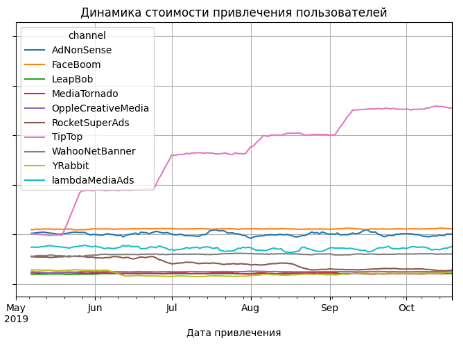

Несмотря на это, вложения рекламного бюджета росли с каждым месяцем - вероятно, это связано с хорошими показателями конверсии и удержания.\
Возможные причины сильного роста стоимости привлечения клиентов:

* Конкуренция:
Конкуренты могут увеличивать ставки за размещение рекламы на той же платформе, что приводит к повышению стоимости для всех рекламодателей.

* Спад целевой аудитории:
Рекламный источник может терять свою целевую аудиторию из-за изменений в поведении пользователей, таких как переключение на другие платформы или каналы.

* Изменения алгоритма:
Рекламные платформы могут вносить изменения в свои алгоритмы показа объявлений, что может повлиять на стоимость рекламы и эффективность кампаний.

* Исчерпание аудитории:
Если рекламная кампания долгое время работает на одном рекламном источнике, целевая аудитория может стать исчерпанной, что приведет к более высокой стоимости привлечения новых клиентов.

* Технические проблемы:
Технические проблемы с рекламным источником или целевой страницей могут привести к снижению эффективности кампании и более высокой стоимости привлечения клиентов.

Учитывая характер графика, а именно заметную периодичность подъема цены и дальнейшее её фиксирование до момента следуюего подъёма, можно исключить конкуренцию, спад целевой аудитории и её исчерпание - потому что в этих случаях подъём на графике не был бы таким равномерным. Остаётся изменение алгоритма платформы и технические проблемы пользователей. Технические проблемы проявились бы в виде слабого удержания, однако у TipTop оно имеет нормальный вид.\
Поэтому можно предположить, что причина постоянного роста САС заключается в изменении алгоритмов рекламной платформы, что привело к тому, что реклама через TipTop не окупается.

### Почему не окупаются **FaceBoom**?

Этот источник имеет самую высокую конверсию среди всех остальных, помимо этого у этого источника - самый высокий % платящих пользователей.\
При этом **FaceBoom** составляет 30% от общего бюджета.\
Оказалось, что платящие пользователи, привлечённые из этого источника, практически не удерживаются в приложении - это хорошо заметно на фоне остальных источников.

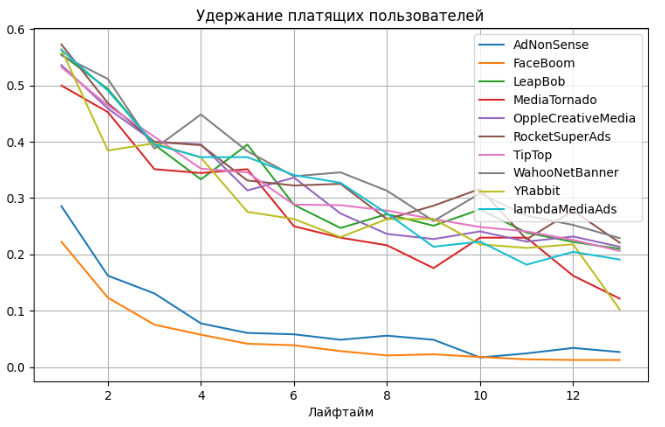


Такое низкое удержание может быть связано с техническими проблемами, с которыми сталкиваются пользователи.\
Взглянем на гистограмму по времени сессии платящих пользователей, пришедших через **FaceBoom**:

Средняя длительность сессии платящих пользователей, пришедших через FaceBoom и AdNonSence:1801.1
Средняя длительность сессии платящих пользователей, пришедших через остальные каналы:1799.9


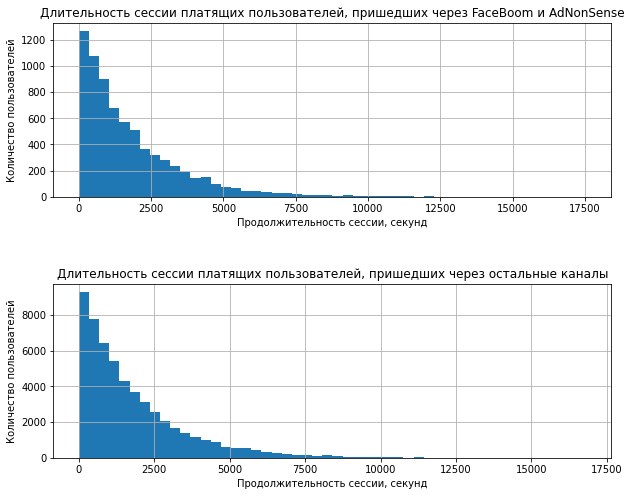

In [44]:
plt.figure(figsize=(10,8))

dur1 = channel_time('FaceBoom', '')
ax1 = plt.subplot(2, 1, 1)
plt.title('Длительность сессии платящих пользователей, пришедших через FaceBoom и AdNonSense')
plt.xlabel('Продолжительность сессии, секунд')
plt.ylabel('Количество пользователей')
dur1.query('payer == True')['dur'].hist(bins=50, ax = ax1);
d1 = dur1['dur'].mean().round(1)
print(f'Средняя длительность сессии платящих пользователей, пришедших через FaceBoom и AdNonSence:{d1}')
plt.subplots_adjust(hspace=0.5)
dur2 = channel_time('FaceBoom', '', dims=True)
ax2 = plt.subplot(2, 1, 2)
plt.title('Длительность сессии платящих пользователей, пришедших через остальные каналы')
plt.xlabel('Продолжительность сессии, секунд')
plt.ylabel('Количество пользователей')
dur2.query('payer == True')['dur'].hist(bins=50, ax = ax2);
d2 = dur2['dur'].mean().round(1)
print(f'Средняя длительность сессии платящих пользователей, пришедших через остальные каналы:{d2}')

Предположение не подтвердилось: среднее время сессии почти одинаково для обоих групп, а гистограмма имеет нормальный вид.\
Значит, дело не в технических ошибках.

### Почему не окупается **AdNonSence**?

Как было указано выше, у AdNonSence также есть проблемы с удержанием платящих пользователей. Кроме того, у этого источника LTV  был нестабилен весь период анализа, что может говорить о падении "качества" пользователей.

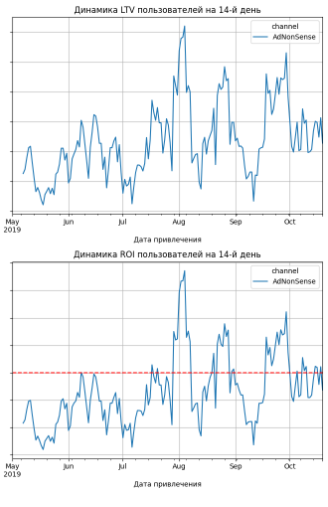

### Почему не окупаются пользователи **из США** и пользователи с **iPhone, Mac и Android**?

Клиенты из этой страны конвертируются гораздо лучше, чем из Европы. Кроме того, они имеют самую высокую пожизненную стоимость, то есть совершают наибольшее количество платежей. Однако заметно, что в отличие от Европы стоимость привлечения клиентов постоянно и очень сильно росла:

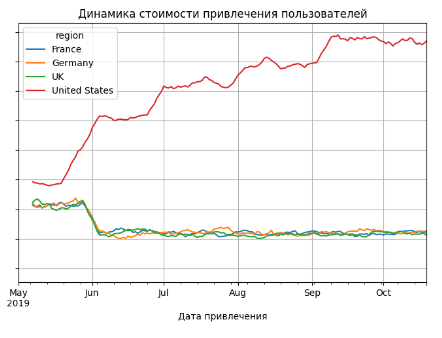

Этот график очень похож на график роста стоимости привлечения пользователей **с iPhone и Android**:

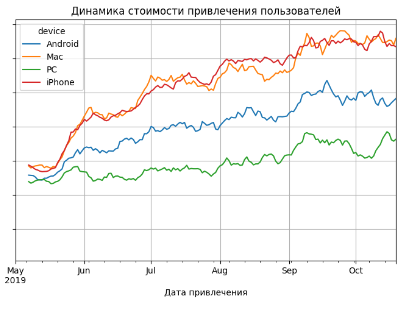


Здесь стоит вспомнить о том, что пользователи с iPhone, Mac и Android не окупаются, в отличие от пользователей с PC.\
На графике выше видно, что стоимость привлечения пользователей с Android также заметно росла.

Логично предположить, что большинство пользователей в США пользуются iPhone и Mac, отсюда такая схожесть графиков. Проверяю это предположение:

In [45]:
apple = profiles.query('region == "United States"').groupby('device').agg({'user_id':'count'}).reset_index()
apple['dole'] = (apple['user_id'] / apple['user_id'].sum() * 100).round(2)
apple.columns = ['Устройство', 'Пользователей в США', '% от всех польз-й в США']
apple.sort_values('Пользователей в США').set_index('Устройство')

,Пользователей в США,% от всех польз-й в США
Устройство,,
PC,6421,10.39
Android,12436,20.11
Mac,15424,24.95
iPhone,27548,44.56


В Америке доля девайсов Apple составляет 70% от всех девайсов, а доля девайсов Apple и Android в сумме даёт более 90% от всех устройств.

In [46]:
apple = profiles.query('region == "United States"').groupby('device').agg({'user_id':'count'}).reset_index()
apple['dole'] = (apple['user_id'] / apple['user_id'].sum() * 100).round(2)
apple.columns = ['Устройство', 'Пользователей в США', '% от всех польз-й в США']
apple.sort_values('Пользователей в США').set_index('Устройство')

,Пользователей в США,% от всех польз-й в США
Устройство,,
PC,6421,10.39
Android,12436,20.11
Mac,15424,24.95
iPhone,27548,44.56


**Подытожу:** из стран не окупается **только Америка**, а из устройств - не окупаются устройства **Apple и Android**, которые составляют **90% рынка** в Америке.\
На графиках роста стоимости привлечения клиента (и по стране, и по девайсам) видно такой же высокий постоянный рост, как у убыточного канала **TipTop**.\
Возможно, этот канал привлекает пользователей из Америки.

Группирую пользователей по странам привлечения в убыточных каналах:

In [47]:
prof = profiles.query(
    'channel == "TipTop" or channel == "FaceBoom" or channel == "AdNonSense"').groupby(['channel',
                                                                                        'region']).agg({'user_id':'count'}).reset_index()
prof.columns = ['Источник', 'Страна', 'Всего привлечено польз-й']
prof.groupby(['Источник', 'Страна']).agg({'Всего привлечено польз-й':'sum'})

Всего привлечено польз-й
Источник   Страна                                 
AdNonSense France                             1366
           Germany                            1219
           UK                                 1295
FaceBoom   United States                     29144
TipTop     United States                     19561

Картина прояснилась: **FaceBoom и TipTop** привлекают пользователей **только из США**. Поскольку эти каналы убыточны, убыточны и пользователи из США в целом.\
Отсюда вытекает и то, что не окупаются клиенты с устройствами iPhone, Mac и Android, ведь они вместе составляют **90%** от всех устройств клиентов из США.

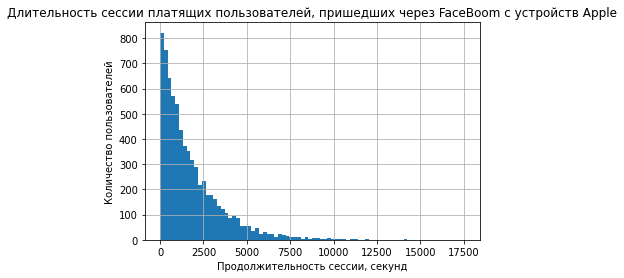

In [48]:
sess = sessions.copy()
sess['dur'] = (sess['session_end'] - 
               sess['session_start']).dt.total_seconds()
sess = sess.query('device!="iPhone" or device !="Mac"').query('channel == "FaceBoom"'
                                                             )

cost = profiles[['user_id', 'payer']]
cst = cost.merge(sess, on='user_id', 
                       how='right')
cst['date'] = pd.to_datetime(cst['session_start'])
plt.title('Длительность сессии платящих пользователей, пришедших через FaceBoom с устройств Apple')
plt.xlabel('Продолжительность сессии, секунд')
plt.ylabel('Количество пользователей')
cst.query('payer == True')['dur'].hist(bins=80);

Заметен высокий пик аномально короткий сессий, а также продолжительный хвост" аномально длинных сессий.

Можно предположить, что причина низкого удержания пользователей с iPhone и Mac заключается в технических ошибках при переходе с платформы FaceBoom.

**Рекомендации**

Канал AdNonSence не окупается - у него нормальное удержание и конверсия, но такие клиенты приносят мало дохода (имеют низкую пожизненную стоимость).\
Источник lambdaMediaAds хорошо показал себя в период анализа: он обладает практически самой высокой окупаемостью из всех, высоким уровнем конверсии после размещения рекламы, а также нормальным удержанием.\
Источники Yrabbit и MediaTornado показали самую высокую окупаемость, однако самое низкое удержание: клиенты окупаются, но быстро "уходят" из приложения. Однако, YRabbit имеет высокие всплески окупаемости - значит, сама реклама эффективна.
В начале июня платформа LeapBob имела очень хорошее удержание на небольшой период. Вероятно, эта реклама была эффективна.\

Лучше всего окупаются клиенты с PC, как за короткий период, так и на длинной дистации. И это несмотря на то, что клиенты с PC приносят меньше дохода и конвертируются хуже, чем остальные.\
Окупаемость у клиентов с Android незначительна, такие клиенты едва окупаются только под конец второй недели.
Из всех стран самая высокая конверсия и "ценность" клиента в Америке, однако удержание - низкое.

## Финальные выводы и рекомендации

### Окупается ли реклама в целом?

Нет, реклама не окупается. К концу двух недель (период окупаемости) привлеченные пользователи не достигают уровня окупаемости.\
Реклама окупалась до середины июня, после чего перестала окупаться, а уровень окупаемости продолжил падение.
Это хорошо видно на графике:

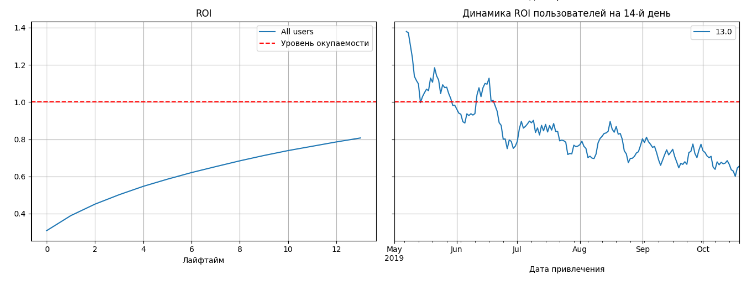

Слева - окупаемость за 14 дней после привлечения пользователя, а справа - динамика этого показателя по месяцам.

### Какие рекламные источники не окупаются, и почему?

Из 10 источников, в которые вкладывался бюджет, не окупаются три:\
**TipTop** (*52% от общего бюджета*), **Faceboom**(*31%*) и **AdNonSense**(*4%*)

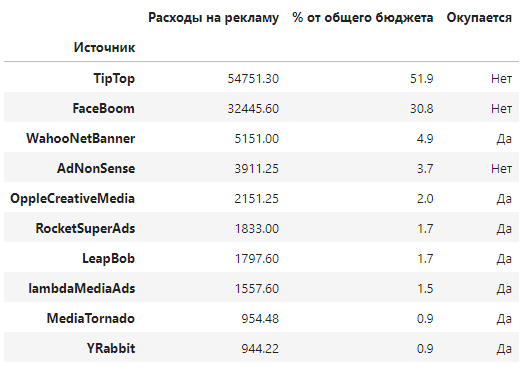.

Таким образом, **более 87%** всего бюджета было вложено в убыточные источники привлечения.

#### TipTop

**TipTop** показывает хорошую конверсию и нормальное удержание. Этот канал вначале окупался, но в середине июня перестал окупаться, и далее окупаемость только падала:

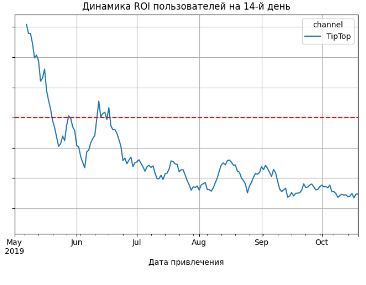

Этот график практически совпадает с графиком окупаемости рекламы в целом.\
Причина не окупаемости TipTop кроется в том, что **стоимость привлечения пользователя через TipTop постоянно росла** через равные промежутки времени, в то время как **у остальных источников** стоимость привлечения пользователя оставалась стабильно **на одном уровне**:

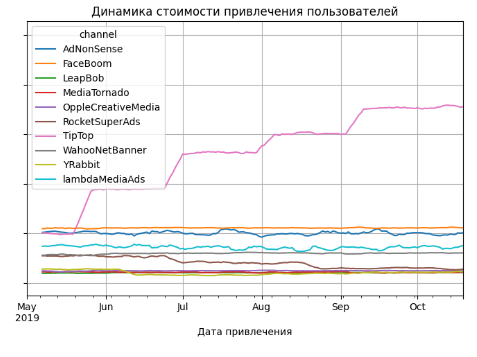

**Чем вызван такой рост стоимости привлечения пользователя?**

Учитывая характер графика, а именно заметную периодичность подъема цены и дальнейшее её фиксирование до момента следуюего подъёма, можно исключить конкуренцию, спад целевой аудитории и её исчерпание - потому что в этих случаях подъём на графике не был бы таким равномерным. Остаётся изменение алгоритма платформы и технические проблемы пользователей. Технические проблемы проявились бы в виде слабого удержания, однако у TipTop оно имеет нормальный вид.\
Вероятно, причина постоянного роста САС заключается **в изменении алгоритмов рекламной платформы, что привело к тому, что реклама через TipTop не окупается**.

#### FaceBoom и AdNonSense

На первый взгляд, FaceBoom и AdNonSense показывают самую высокую конверсию среди всех источников, а также самый высокий % платящих пользователей.
Однако ти источники также не окупаются. Почему?\
При анализе удержания стало ясно, что платящие пользователи, пришедшие через эти каналы, в приложении почти не удерживаются - заметна большая разница с остальными источниками:

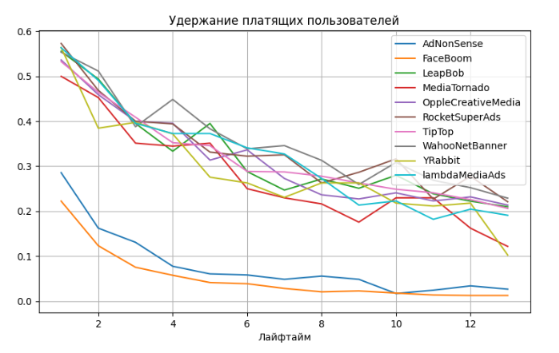


Причиной низкого удержания могут являться технические ошибки, с которыми сталкиваются пользователи, пришедшие через эти каналы.\
После анализа длительности сессий таких пользователей и её сравнения с длительностью сессии пользователей, пришедших через другие источники, было выявлено, что сессии практически не отличаются по длительности.

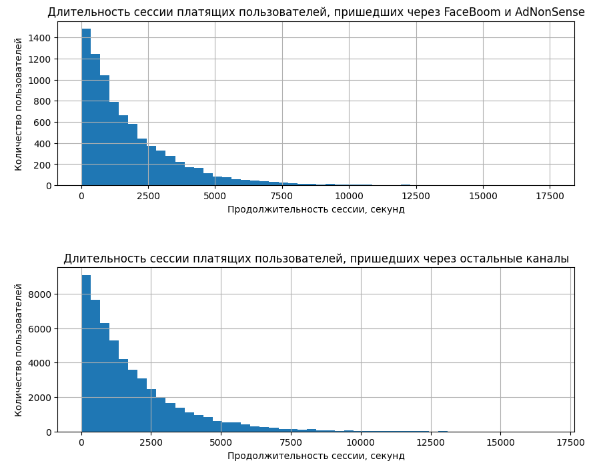

Теперь важно отметить, что FaceBoom привлекает пользователей только из Америки, а AdNonSense только из остальных стран за исключением США.\
У AdNonSense выявлено, что график LTV, или пожизненной стоимости клиента, во-первых, нестабилен, а во-вторых почти совпадает с ROI:

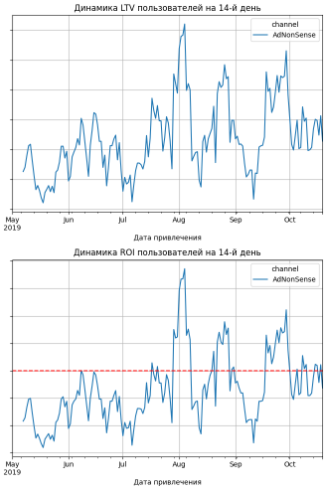

**AdNonSense** не окупается из-за нестабильности LTV пользователей. Возможные причины:

* **Высокие затраты на привлечение:** Хотя канал может привлекать высококачественный трафик и приносить высокий LTV, стоимость привлечения одного пользователя может быть слишком высокой, чтобы обеспечить прибыльность.ь.
* **Отток пользователей:** Несмотря на высокий LTV, может наблюдаться высокий отток пользователей, что снижает общую пожизненную ценность.
* **Сезонные колебания:** Доход от приложения может зависеть от сезонных колебаний, что может привести к нерентабельности канала привлечения в определенные периоды временсти.


**FaceBoom** не окупается из-за низкого удержания, причём это не связано с изменением "качества" пользователей.\
Стоит принять во внимание то, что FaceBoom привлекает только пользователей из Америки, где большая часть девайсов - устройства Apple. При этом и Америка. и эти виды устройств не окупаются. Оцениваю время сессий платящих пользователей, пришедших через Apple с FaceBoom:

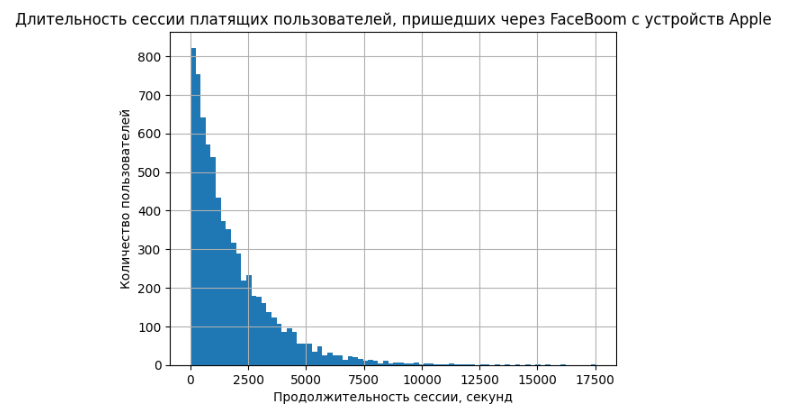

Заметен высокий пик аномально коротких сессий, который может указывать на технические ошибки.\
**Faceboom**, вероятно, не окупается из-за технических проблем пользователей при использовании девайсов Apple.


#### Проблемные регионы и устройства

Как отмечено выше, из регионов не окупаются США, а также не окупаются iPhone, Mac и Android.\
Более 80% рекламного бюджета вложены в убыточные TipTop и FaceBoom, которые привлекали только пользователей из Америки, это могло стать причиной такой статистики.\
Кроме этого, стоит проверить приложение на технические ошибки, с которыми сталкиваются платящие пользователи, приходящие через FaceBoom на устройствах Apple.

## Рекомендации

При анализе было выявлено несколько рекламных источников, которые:
* окупаются
* показывают хорошую конверсию
* дают хорошее удержание

**LambdaMediaAds** и **RocketSuperAds** соответствуют этим критериям.\
Кроме этого, оба канала дают хороший процент платящих пользователей, а также имеют стоимость привлечения клиента ниже средней по проекту.\
Анализирую распределение стран по этим источникам:

In [49]:
profiles.query(
    'channel =="lambdaMediaAds" or channel == "RocketSuperAds"'
                ).groupby(['channel', 'region']).agg({'user_id':'count'})

user_id
channel        region                
RocketSuperAds United States     4448
lambdaMediaAds France             742
               Germany            649
               UK                 758

**RocketSuperAds** привлекает пользователей из США, а **lambdaMediaAds** - из Европы.

Кроме этого выявлено, что из всех устройств окупаются только клиенты с PC. И это несмотря на то, что такие клиенты конвертируются и приносят платежей меньше, чем остальные. Рекламу для платформы PC и Android лучше давать в Европе, а для Apple - в США.